In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

import torch
import torch.utils.data as data
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [3]:
DATA_DIR = {
    "train": "data/training.csv",
    "preprocessed": "preprocessed.csv",
    "test": "data/test.csv"
}

In [4]:
IMG_SIZE = 96

In [5]:
datadict = {
    "train": {},
    "test" : {}
}


In [6]:
from tqdm.notebook import tqdm
with open(DATA_DIR["preprocessed"], "r") as f:
    reader = csv.reader(f)
    header = next(reader)
    for i in header:
        datadict["train"][i] = []
    for row in tqdm(reader):
        for h,i in zip(header,row):
            datadict["train"][h].append(i)

In [7]:
# Load test samples

with open(DATA_DIR["test"], "r") as f2:
    reader2 = csv.reader(f2)
    header = next(reader2)
    for i in header:
        datadict["test"][i] = []
    for row in tqdm(reader2):
        for h,i in zip(header,row):
            datadict["test"][h].append(i)

In [8]:
class FacialDataset(data.Dataset):
    def __init__(self, datadict, train=True):
        self.datadict = datadict
        self.header = list(datadict.keys())
        self.IMG_SIZE = IMG_SIZE
        self.train = train
        
    def __getitem__(self, idx):
        
        # Get facial keypoint #
        
        if self.train:
            x = []
            for i in self.header[:-1]:
                x.append(int(float(self.datadict[i][idx])))
            landmark = np.array(x).reshape(-1,2)
        
        # Get gray image #       
        img = self.datadict["Image"][idx]
        img = str.split(img)
        img = np.array([int(i) for i in img]).reshape((self.IMG_SIZE,self.IMG_SIZE))
        
        return (img , landmark) if self.train else img
    
    def __len__(self):
        return len(self.datadict["Image"])

In [9]:
BATCH_SIZE = 64

trainset = FacialDataset(datadict["train"])
testset = FacialDataset(datadict["test"],train=False)
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers= 0)
testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers= 0)

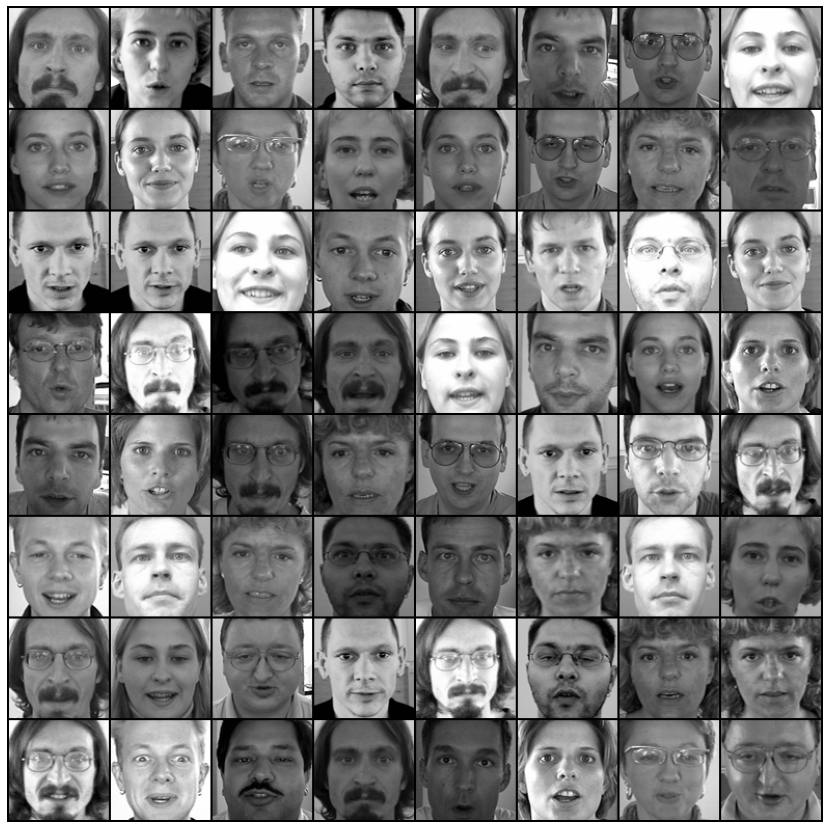

In [10]:
# Visualize some training samples

def visualize_training_samples(trainloader):
    fig = plt.figure(figsize=(15,15))
    dataiter,_ = next(iter(trainloader))
    dataiter = dataiter.view(-1,1,IMG_SIZE,IMG_SIZE)
    grid_img = torchvision.utils.make_grid(dataiter)
    plt.imshow(grid_img.numpy().transpose((1,2,0)))
    plt.axis("off")
    plt.show()
    
visualize_training_samples(trainloader)

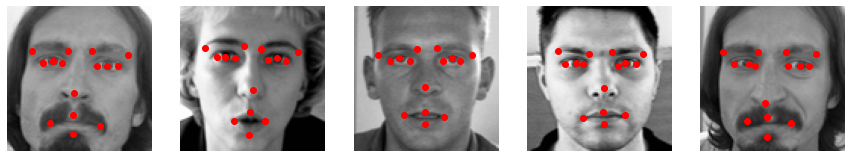

In [11]:
def visualize_coordinate(trainloader, NUM_PIC = 5):
    img, key_px = next(iter(trainloader))
    img = img.view(-1,1,IMG_SIZE,IMG_SIZE)
    fig = plt.figure(figsize=(15,15))
    for ids,(i,j) in enumerate(zip(img,key_px)):
        fig.add_subplot(1,5,ids+1)
        plt.imshow(i.numpy().transpose((1,2,0)).squeeze(), cmap="gray")
        plt.scatter(j[:,0],j[:,1],color="red")
        plt.axis("off")
        if (ids+1 == 5):
            break
    plt.show()
    
visualize_coordinate(trainloader)

In [12]:
NUM_KEYPOINTS = len(list(datadict["train"].keys())[:-1])
print(f"Number of unique keypoints: {NUM_KEYPOINTS}")    

Number of unique keypoints: 30


In [13]:
datatable = pd.read_csv(DATA_DIR["preprocessed"])

In [14]:
display(datatable)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,67.029093,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,66.626011,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,67.515161,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,66.724988,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [15]:
print(datatable.isnull().sum())

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64


In [16]:
from facenet_pytorch import InceptionResnetV1
import cv2
from PIL import Image
model = InceptionResnetV1(pretrained="vggface2").eval()
model.classify = True
#model.conv2d_1a[0] = nn.Conv2d(1,32,kernel_size=(3, 3), stride=(2, 2), bias=False)
for params in model.parameters():
    params.requires_grad = False
model.logits = nn.Linear(512,NUM_KEYPOINTS).to(device)
model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()
print(model)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [17]:
from torchsummary import summary

summary(model, (3,IMG_SIZE,IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 47, 47]             864
       BatchNorm2d-2           [-1, 32, 47, 47]              64
              ReLU-3           [-1, 32, 47, 47]               0
       BasicConv2d-4           [-1, 32, 47, 47]               0
            Conv2d-5           [-1, 32, 45, 45]           9,216
       BatchNorm2d-6           [-1, 32, 45, 45]              64
              ReLU-7           [-1, 32, 45, 45]               0
       BasicConv2d-8           [-1, 32, 45, 45]               0
            Conv2d-9           [-1, 64, 45, 45]          18,432
      BatchNorm2d-10           [-1, 64, 45, 45]             128
             ReLU-11           [-1, 64, 45, 45]               0
      BasicConv2d-12           [-1, 64, 45, 45]               0
        MaxPool2d-13           [-1, 64, 22, 22]               0
           Conv2d-14           [-1, 80,

In [18]:
def train_process(model, optimizer, criterion, trainloader):
    total_loss = 0
    model.train()
    
    for (img,key_px) in tqdm(trainloader):
        optimizer.zero_grad()
        img = img.unsqueeze(1)
        img = torch.cat([img,img,img], 1)
        img = Variable(img.float()).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
        key_px = Variable(key_px.float()).view(key_px.size(0),-1).to(device)

        output = model(img)
        loss = criterion(output, key_px)

        loss.backward()
        optimizer.step()
        total_loss+= loss.data
    
    return  total_loss/len(trainloader)
    

In [19]:
def evaluate_process(model, testloader, NUM_PIC=3):
    model.eval()
    
    img = next(iter(testloader))
    img_show = img[:][:NUM_PIC]

    with torch.no_grad():
        img = img_show.unsqueeze(1)
        img = torch.cat([img,img,img], 1)
        img = Variable(img.float()).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
        
        output = model(img).view(NUM_PIC,-1,2)

    fig = plt.figure(figsize=(15,10))
    for ids,(i,j) in enumerate(zip(img_show,output)):
    
        fig.add_subplot(1,NUM_PIC,ids+1)
        j = j.cpu().numpy()
        
        plt.imshow(i, cmap="gray")
        plt.scatter(j[:,0],j[:,1], color="red")
       
    plt.show()


In [20]:
TRAIN_DATA = 0
if TRAIN_DATA:
    EPOCHS = 30
    loss_list = []
    print("Start training...")
    for epoch in range(EPOCHS):
        train_loss = train_process(model,optimizer,criterion,trainloader)
        
        print(f"Epoch: [{epoch+1}|{EPOCHS}] | Training Loss: {train_loss}")
        loss_list.append(train_loss)
        if epoch%5 == 0:
            torch.save(model.state_dict(), "model/model5.pt")
            evaluate_process(model, testloader,3)
    print("Training completed!")

In [21]:
def plot(loss_list , EPOCHS):
    plt.plot(range(EPOCHS), loss_list)
    plt.title("Training loss")
    plt.show()
if TRAIN_DATA:
    plot(loss_list, EPOCHS)

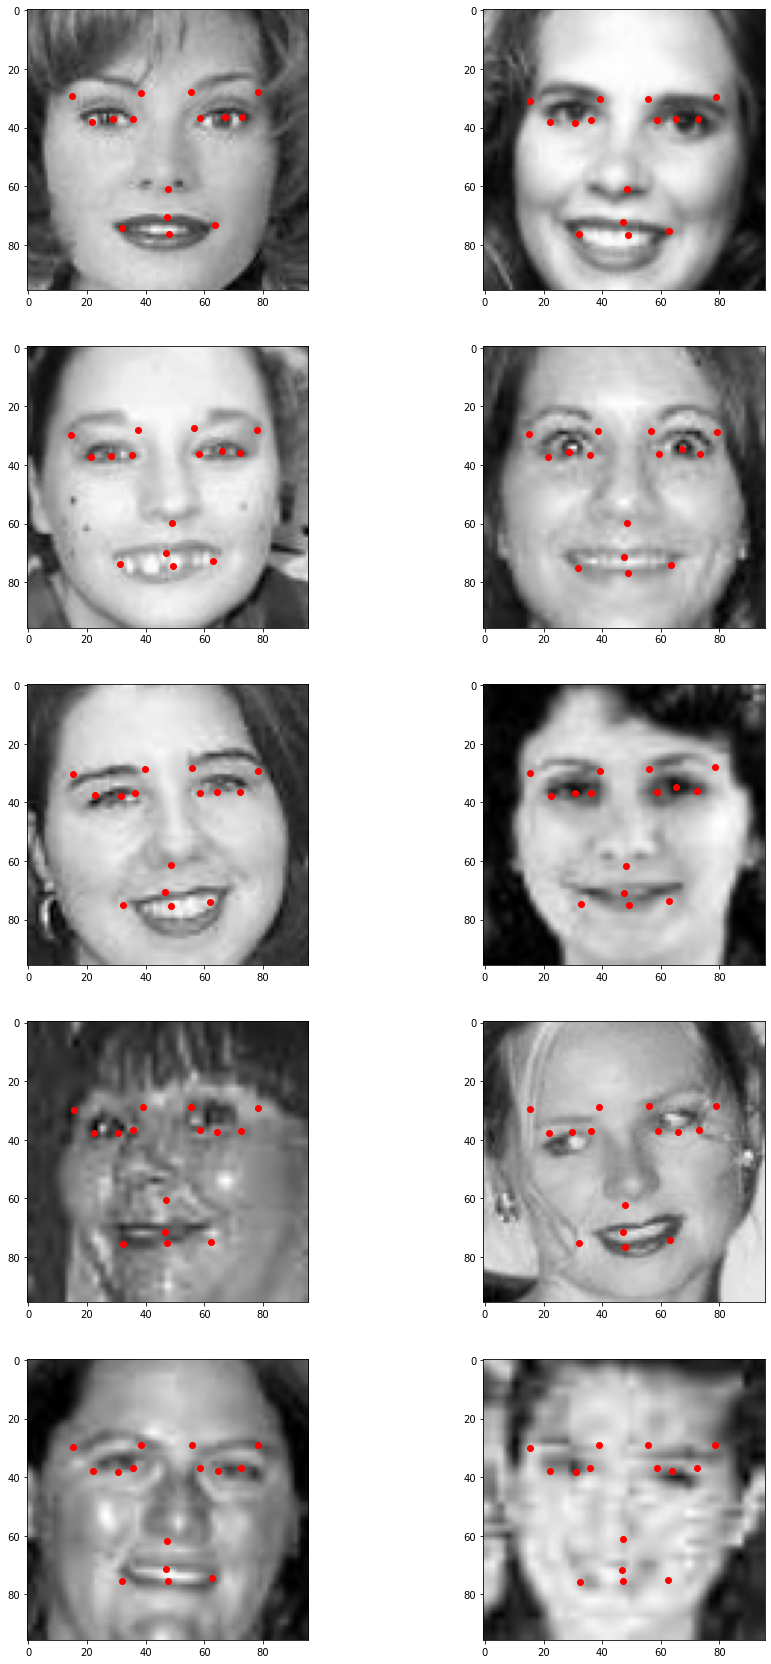

In [32]:
if not TRAIN_DATA:
    model.load_state_dict(torch.load("model/model5.pt"))

def predict_test(model, testloader, NUM_PIC=10):
    model.eval()
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    itera = iter(testloader)
    for i in range(np.random.randint(50)):
        img = next(itera)
    
    img_show = img[:][a:a+NUM_PIC]

    with torch.no_grad():
        img = img_show.unsqueeze(1)
        img = torch.cat([img,img,img], 1)
        img = Variable(img.float()).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
        
        output = model(img).view(NUM_PIC,-1,2)
        
    fig = plt.figure(figsize=(15,30))
    for ids,(i,j) in enumerate(zip(img_show,output)):
    
        fig.add_subplot(5,2,ids+1)
        j = j.cpu().numpy()
        
        plt.imshow(i, cmap="gray")
        plt.scatter(j[:,0],j[:,1], color="red")
       
    plt.show()
    
predict_test(model,testloader)

In [36]:
def submission(model, testloader):
   
    model.eval()
    with torch.no_grad():
        for img in tqdm(testloader):

            img = img.unsqueeze(1)
            img = torch.cat([img,img,img], 1)
            img = Variable(img.float()).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)


            output = model(img)

            output = output.cpu().numpy()
            print(output)
            break
        
submission(model,testloader)

[[66.62067  35.676384 28.593624 ... 71.1815   49.00967  76.147964]
 [66.76874  37.25524  28.931274 ... 71.95943  48.43008  79.58313 ]
 [66.12478  36.681625 29.581217 ... 71.96286  48.3166   77.373955]
 ...
 [66.01528  37.61127  30.042252 ... 72.66734  47.718132 81.21873 ]
 [65.63467  37.413822 30.143059 ... 71.81952  47.668488 76.14895 ]
 [65.0552   37.600105 30.466328 ... 71.6675   47.532326 75.97923 ]]
